# <center> ***Anomaly-Driven Video Summarization***</center>

#### **Vishnu Priyan Sellam Shanmugavel**
#### **A20561323**
#### **CS512 - F24** 

<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


from IPython.display import clear_output
import warnings
# warnings.filterwarnings('ignore')

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [ ]:
train_dir = "dataset/UCF_Crime_Organized/Train"
test_dir = "dataset/UCF_Crime_Organized/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 10
LR =  0.00003
NUM_CLASSES = 14
IMG_WIDTH = 64
NUM_FRAMES = 16  # Desired number of frames per video
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"NormalVideos",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import cv2

# Initialize LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(CLASS_LABELS)

def process_frames(video_frames_dir, num_frames=NUM_FRAMES, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    # Get all frame file paths and sort them
    frame_files = sorted([os.path.join(video_frames_dir, f) for f in os.listdir(video_frames_dir) if f.endswith('.png')])
    total_frames = len(frame_files)
    
    # Determine step to sample frames uniformly if there are more frames than needed
    step = max(1, total_frames // num_frames)
    selected_frames = frame_files[::step][:num_frames]
    
    # Load and resize frames
    frames = []
    for frame_path in selected_frames:
        img = cv2.imread(frame_path)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            frames.append(img)
    
    # Pad with black frames if necessary
    while len(frames) < num_frames:
        frames.append(np.zeros((img_height, img_width, 3), dtype=np.uint8))
    
    # Convert frames to numpy array and normalize
    return np.array(frames) / 255.0

def load_dataset(data_dir):
    X_data = []
    y_data = []
    for class_label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_label)
        if os.path.isdir(class_dir):
            for video_folder in os.listdir(class_dir):
                video_frames_dir = os.path.join(class_dir, video_folder)
                if os.path.isdir(video_frames_dir):
                    frames = process_frames(video_frames_dir)
                    X_data.append(frames)
                    y_data.append(class_label)
    
    # Encode labels
    y_data = label_encoder.transform(y_data)
    y_data = to_categorical(y_data, num_classes=len(CLASS_LABELS))
    return np.array(X_data), np.array(y_data)

# Load Train and Test Data
X_train, y_train = load_dataset(train_dir)
X_test, y_test = load_dataset(test_dir)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

def build_c3d_model(input_shape=(16, 64, 64, 3), num_classes=14):
    model = Sequential()
    
    # 1st layer group
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same'))
    
    # 2nd layer group
    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same'))
    
    # 3rd layer group
    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same'))
    
    # 4th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same'))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

c3d_model = build_c3d_model()
c3d_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
c3d_model.summary()


/Users/vishnu/garage/cs512-f24-sellamshanmugavel-vishnupriyan/cv_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 16, 64, 64, 64) │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 32, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 16, 32, 32,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 16, 16, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 16, 16, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 8, 8, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 4, 8, 8, 512)   │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 2, 4, 4, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    67,112,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │        57,358 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,602,638 (337.99 MB)

 Trainable params: 88,602,638 (337.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the C3D model
c3d_model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 561s 26s/step - accuracy: 0.4203 - loss: 13.8459 - val_accuracy: 0.0000e+00 - val_loss: 5.5723
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 531s 25s/step - accuracy: 0.6228 - loss: 1.4001 - val_accuracy: 0.0000e+00 - val_loss: 10.3846
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 510s 24s/step - accuracy: 0.6232 - loss: 1.3650 - val_accuracy: 0.0000e+00 - val_loss: 12.1615
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 447s 21s/step - accuracy: 0.6112 - loss: 1.4486 - val_accuracy: 0.0000e+00 - val_loss: 13.3963
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 446s 21s/step - accuracy: 0.6503 - loss: 1.2811 - val_accuracy: 0.0000e+00 - val_loss: 10.3200
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 442s 21s/step - accuracy: 0.6320 - loss: 1.2845 - val_accuracy: 0.0000e+00 - val_loss: 13.2749
Epoch 7/10
 6/21 ━━━━━━━━━━━━━━━━━━━━ 5:22 21s/step - accuracy: 0.6730 - loss: 1.2639

In [ ]:
c3d_model.save("c3d_model.h5")
c3d_model.save("c3d_model.keras")

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step


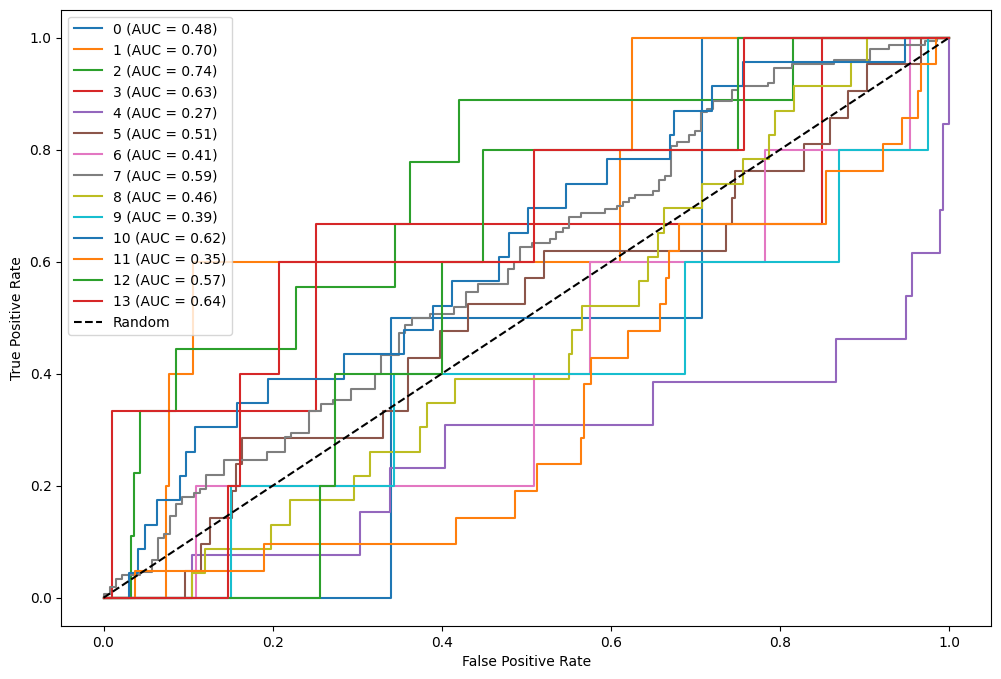

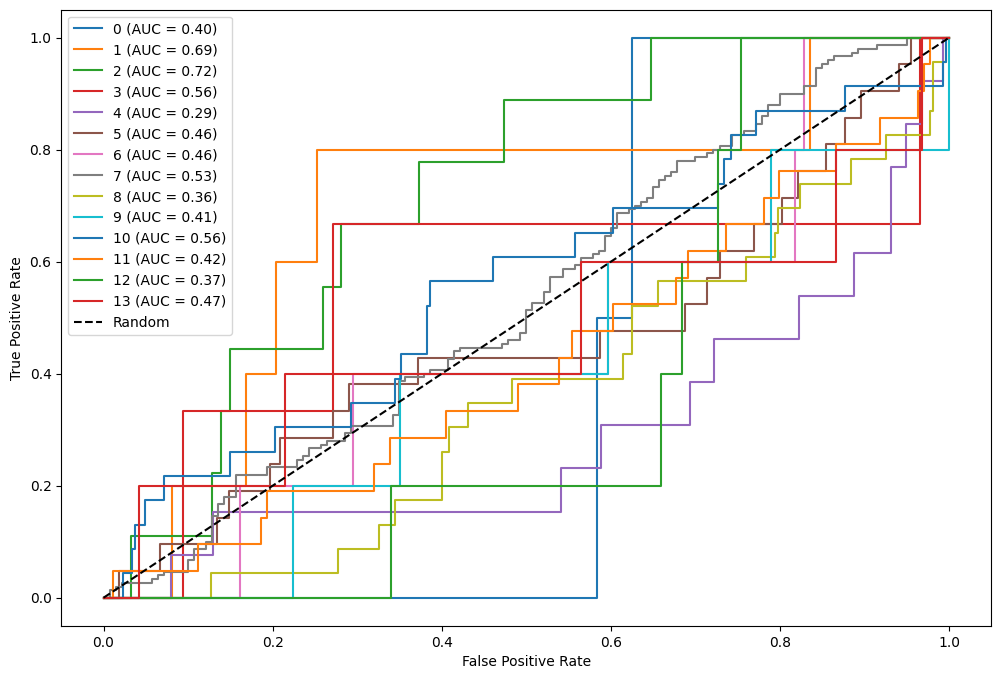

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

def plot_multiclass_roc(y_test, y_pred, class_labels):
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot ROC for each class
    for i, label in enumerate(lb.classes_):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        ax.plot(fpr, tpr, label=f'{label} (AUC = {auc(fpr, tpr):.2f})')

    # Plot the random chance line
    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    plt.show()

# Example usage with predictions
y_pred_c3d = c3d_model.predict(X_test)   # Ensure shape is (n_samples, n_classes)

# Plot ROC-AUC for each model
plot_multiclass_roc(y_test, y_pred_c3d, CLASS_LABELS)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Define the class labels
CLASS_LABELS = ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 
                "NormalVideos", 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 
                'Stealing', 'Vandalism']

# Initialize and fit LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(CLASS_LABELS)

# Transform y_test to integer labels and then to one-hot encoding
y_test_encoded = label_encoder.transform(y_test)  # Convert labels to integer encoding
y_test_one_hot = to_categorical(y_test_encoded, num_classes=len(CLASS_LABELS))

# Transform predictions to one-hot or probability format if not already in that shape
y_pred_c3d = c3d_model.predict(X_test)  # Ensure (n_samples, n_classes) output
y_pred_resnet3d = resnet3d_model.predict(X_test)

# Plot ROC for both models
plot_multiclass_roc(y_test_one_hot, y_pred_c3d, CLASS_LABELS)
plot_multiclass_roc(y_test_one_hot, y_pred_resnet3d, CLASS_LABELS)


ValueError: y should be a 1d array, got an array of shape (290, 14) instead.